In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("completed_flat_price_2017_2023.csv")

### EDA

In [2]:
# converting remaining_lease to int format:
df_cleaned=df

def three_sd_range(series):
    mean = series.mean()
    sd = series.std()
    low = mean - 3*sd
    high = mean + 3*sd
    
    return (low, high)

lower, upper = three_sd_range(df["resale_price"])
df_cleaned  = df[ (df.resale_price>=lower) & (df.resale_price<=upper)]

df_cleaned=df


def convert_lease_to_int(lease_str):
    parts = lease_str.split()
    years = int(parts[0])
    return years

df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)

# encoding flat_type and storey_range to ordinal data:
labelencoder = LabelEncoder()
df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
df_cleaned['storey_range_encoded'] = labelencoder.fit_transform(df_cleaned['storey_range'])

# Add a 'year' column to df2 by converting 'month' to datetime and extracting the year
df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year

# extracting features:
df2= df_cleaned[['flat_type_encoded', 'storey_range_encoded',
                 'floor_area_sqm', 'remaining_lease_years',
                 'resale_price', 'year'
                 ]]

df2

flat_type_encoded  storey_range_encoded  floor_area_sqm  \
0                       1                     3            44.0   
1                       2                     0            67.0   
2                       2                     0            67.0   
3                       2                     1            68.0   
4                       2                     0            67.0   
...                   ...                   ...             ...   
146867                  4                     0           127.0   
146868                  4                     3           122.0   
146869                  5                     2           181.0   
146870                  5                     3           146.0   
146871                  5                     0           142.0   

        remaining_lease_years  resale_price  year  
0                          61      232000.0  2017  
1                          60      250000.0  2017  
2                          62      262000.0  2017  
3                          62      265000.0  2017  
4                          62      265000.0  2017  
...                       ...           ...   ...  
146867                     64      700000.0  2023  
146868                     64      700000.0  2023  
146869                     68     1068000.0  2023  
146870                     64      838000.0  2023  
146871                     63      765000.0  2023  

[146872 rows x 6 columns]

In [3]:
# Splitting into 3 df:
full_dataset = df2
precovid_dataset = df2[(df2['year'] >= 2017) & (df2['year'] <= 2019)]
postcovid_dataset = df2[(df2['year'] >= 2020) ]

### Binning

/var/folders/xz/qc1454j97m3fyrx6gcldlxr40000gn/T/ipykernel_46753/3852828245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postcovid_dataset['price_range'] = pd.cut(postcovid_dataset['resale_price'],


price_range
300K-450K    19698
450K-600K    19493
600K-750K     8860
750K<         5285
0-300K        4495
Name: count, dtype: int64

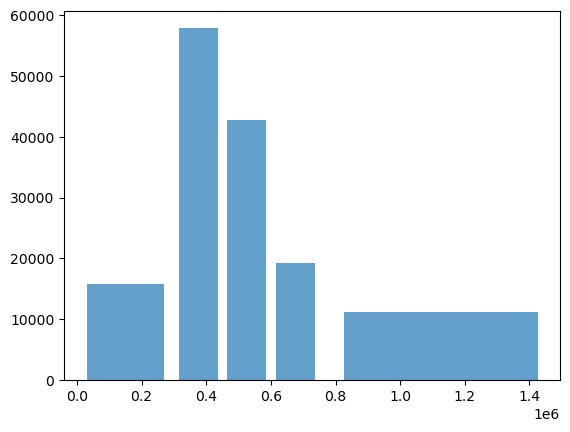

In [4]:

# Binning resale prices into ranges
bins = [0, 300000, 450000, 600000, 750000, 1500000] 
labels = ['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K<']
postcovid_dataset['price_range'] = pd.cut(postcovid_dataset['resale_price'], 
                            bins=bins, labels=labels)

plt.hist(df2['resale_price'], bins=bins, rwidth=0.8, alpha=0.7)

# Select features and target
X = postcovid_dataset[['floor_area_sqm', 'remaining_lease_years', 
        'storey_range_encoded', 'flat_type_encoded']]
y = postcovid_dataset['price_range']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy,report

y_train.value_counts()

In [5]:
####### reusable methods:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image, display
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np

# Hyper paramter tuning (Bayesian Optimisation):
def hyperTuning(X_train, y_train):
    def dtree_optimize( max_depth, min_samples_split, min_samples_leaf):
        # Ensure the hyperparameters are integers because they must be discrete for a DecisionTree
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        
        # Define the classifier with the hyperparameters
        clf = DecisionTreeClassifier(max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=42)
        
        # Perform cross-validation and return the mean accuracy
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        
        return np.mean(scores)
    
    # Define the bounds of the hyperparameters
    pbounds = {
        'max_depth': (1, 8),  
        'min_samples_split': (2, 20),  
        'min_samples_leaf': (1, 10)  
    }

    # Initialize Bayesian Optimization
    optimizer = BayesianOptimization(
        f=dtree_optimize,
        pbounds=pbounds,
        random_state=42,
    )

    # Perform optimization
    optimizer.maximize(
        init_points=2,  # Number of randomly chosen points to sample the target function before fitting the GP (Gaussian Process)
        n_iter=10,  # Number of iterations to perform
    )

    # Print the best hyperparameters found
    print("Best hyperparameters:", optimizer.max['params'])


# Base Tree
def createTree(X_train, X_test, y_train, y_test, cols, max_depth, min_samples_split, min_samples_leaf):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth,  min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf, random_state=42) 
    # clf = DecisionTreeClassifier(criterion='gini', random_state=42) 


    clf.fit(X_train, y_train)
    print("--------------BASE CLASSIFICATION TREE--------------")
    print('Number of nodes in the tree:', clf.tree_.node_count)

    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data, 
                    feature_names=cols,  
                    class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K and more'],
                    filled=True, rounded=True,  
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    display(Image(graph.create_png()))
    # Predict on test data
    y_pred = clf.predict(X_test)

   # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy.round(4)}")

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted Average Precision: {precision.round(4)}")
    print(f"Weighted Average Recall: {recall.round(4)}")
    print(f"Weighted Average F1 Score: {f1.round(4)}")

    # Generate a classification report
    report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
    print("Classification Report:")
    print(report)

# Catboost:
def catBoostTree(X_train, X_test, y_train, y_test, cols, max_depth, min_samples_split, min_samples_leaf):
    catboost_model = CatBoostClassifier(
    iterations=1000, 
    depth=max_depth, 
    learning_rate=0.1, 
    loss_function='MultiClass',  
    verbose=200,  # To limit the amount of output during training
    random_seed=42
    )
    # Fit the model
    catboost_model.fit(X_train, y_train)
    print("--------------CATBOOST CLASSIFICATION TREE--------------")


    # Predict on test data
    y_pred = catboost_model.predict(X_test)

   # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy.round(4)}")

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted Average Precision: {precision.round(4)}")
    print(f"Weighted Average Recall: {recall.round(4)}")
    print(f"Weighted Average F1 Score: {f1.round(4)}")

    # Generate a classification report
    report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
    print("Classification Report:")
    print(report)

# AdaBoost:
def adaBoostTree(X_train, X_test, y_train, y_test, cols, max_depth, min_samples_split, min_samples_leaf):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth,  min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, random_state=42) 

    clf = AdaBoostClassifier(clf, n_estimators=10, learning_rate=0.1, random_state=42)
    clf.fit(X_train, y_train)
    print("--------------ADABOOST CLASSIFICATION TREE--------------")
    # Predict on test data
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy.round(4)}")

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted Average Precision: {precision.round(4)}")
    print(f"Weighted Average Recall: {recall.round(4)}")
    print(f"Weighted Average F1 Score: {f1.round(4)}")

    # Generate a classification report
    report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
    print("Classification Report:")
    print(report)

# Bagging:
def baggingTree(X_train, X_test, y_train, y_test, cols, max_depth, min_samples_split, min_samples_leaf):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth,  min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, random_state=42) 

    clf = BaggingClassifier(clf, n_estimators=10, random_state=42)
    clf.fit(X_train, y_train)
    print("--------------BAGGING CLASSIFICATION TREE--------------")
    # Predict on test data
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy.round(4)}")

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted Average Precision: {precision.round(4)}")
    print(f"Weighted Average Recall: {recall.round(4)}")
    print(f"Weighted Average F1 Score: {f1.round(4)}")

    # Generate a classification report
    report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
    print("Classification Report:")
    print(report)

### Continuous variables decision tree

#### Running general tree

Number of nodes in the tree: 63


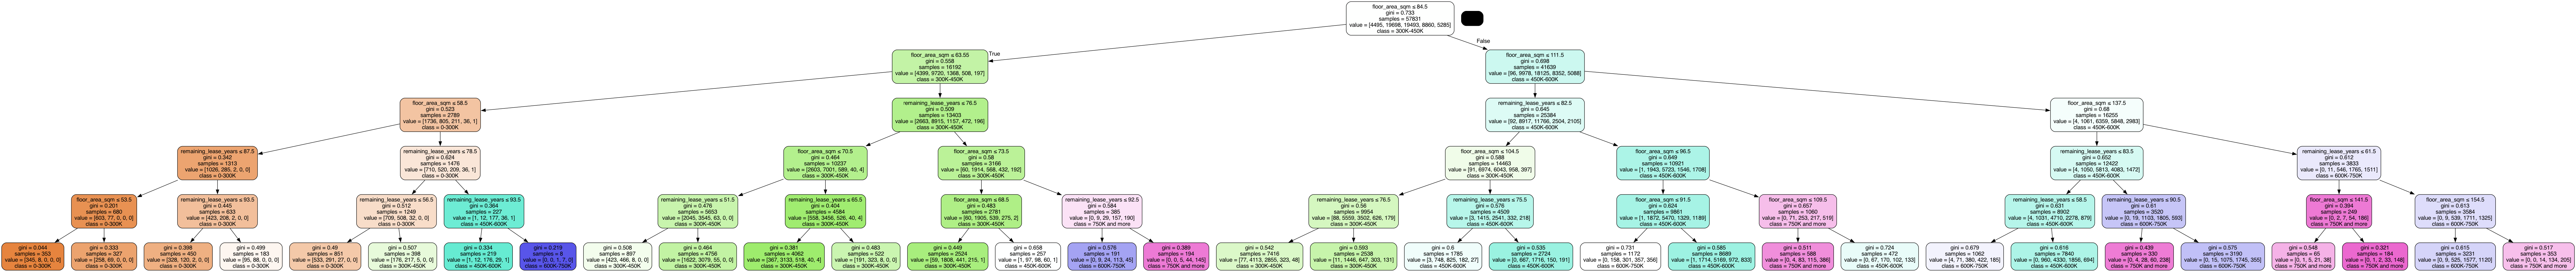

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42) 
# clf = DecisionTreeClassifier(criterion='gini', random_state=42) 


feature_cols = ['floor_area_sqm', 'remaining_lease_years']
X_train, X_test, y_train, y_test = train_test_split(X[feature_cols], y, test_size=0.3, random_state=42)


clf.fit(X_train, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K and more'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

#### Hyper parameter tuning

In [7]:
hyperTuning(X_train, y_train)

|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------
| 1         | 0.5348    | 3.622     | 9.556     | 15.18     |
| 2         | 0.5856    | 5.191     | 2.404     | 4.808     |
| 3         | 0.5856    | 5.468     | 2.231     | 4.608     |
| 4         | 0.602     | 7.608     | 9.698     | 2.062     |
| 5         | 0.4815    | 1.0       | 10.0      | 2.0       |
| 6         | 0.6103    | 8.0       | 6.806     | 5.273     |
| 7         | 0.6107    | 8.0       | 1.0       | 10.93     |
| 8         | 0.6107    | 8.0       | 1.0       | 18.49     |
| 9         | 0.4815    | 1.0       | 1.0       | 20.0      |
| 10        | 0.6105    | 8.0       | 5.959     | 10.97     |
| 11        | 0.6102    | 8.0       | 6.77      | 20.0      |
| 12        | 0.6107    | 8.0       | 3.974     | 15.43     |
Best hyperparameters: {'max_depth': 8.0, 'min_samples_leaf': 3.974329209062833, 'min_samples_split': 15.433776422642591}


In [8]:
max_depth = 8
min_samples_split = 4
min_samples_leaf = 15

--------------BASE CLASSIFICATION TREE--------------
Number of nodes in the tree: 431
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.708476 to fit



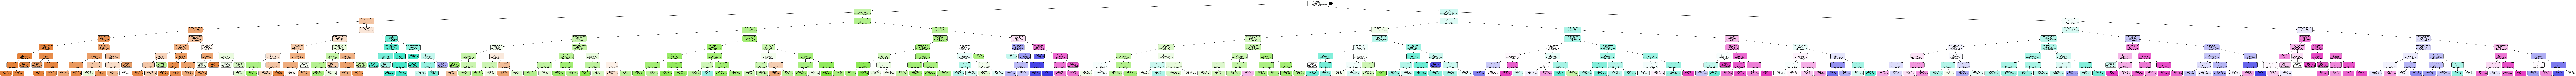

Model Accuracy: 0.6099
Weighted Average Precision: 0.6111
Weighted Average Recall: 0.6099
Weighted Average F1 Score: 0.6014
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.71      0.44      0.54      1828
   300K-450K       0.64      0.75      0.69      8403
   450K-600K       0.59      0.66      0.62      8466
   600K-750K       0.53      0.45      0.49      3853
       750K+       0.64      0.33      0.43      2235

    accuracy                           0.61     24785
   macro avg       0.62      0.52      0.56     24785
weighted avg       0.61      0.61      0.60     24785

0:	learn: 1.4986804	total: 66.2ms	remaining: 1m 6s
200:	learn: 0.8799230	total: 1.49s	remaining: 5.91s
400:	learn: 0.8561004	total: 2.89s	remaining: 4.31s
600:	learn: 0.8439402	total: 4.34s	remaining: 2.88s
800:	learn: 0.8362045	total: 5.71s	remaining: 1.42s
999:	learn: 0.8304434	total: 7.09s	remaining: 0us
--------------CATBOOST CLASSIFICATION TREE-------------

In [9]:
createTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)
catBoostTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)
adaBoostTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)
baggingTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)


#### Encoded variables decision tree

--------------BASE CLASSIFICATION TREE--------------
Number of nodes in the tree: 107


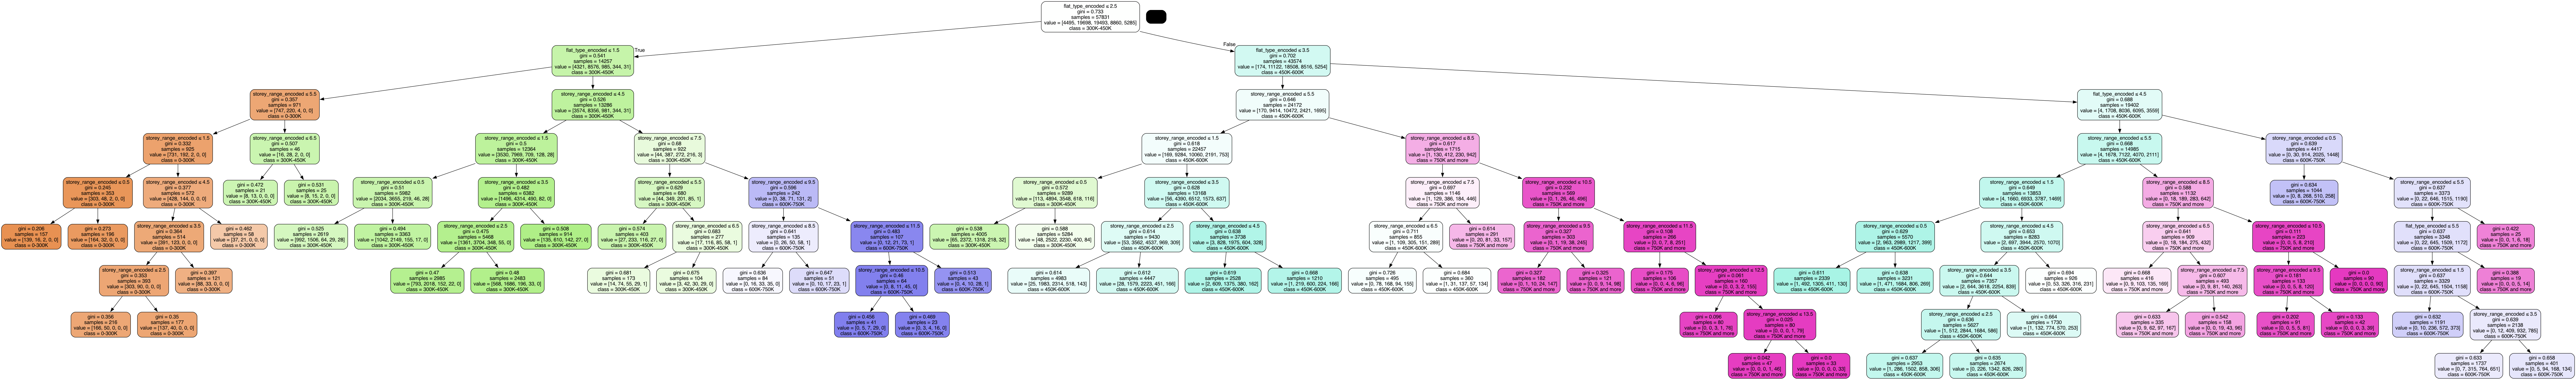

Model Accuracy: 0.5441
Weighted Average Precision: 0.5603
Weighted Average Recall: 0.5441
Weighted Average F1 Score: 0.5171
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.75      0.16      0.27      1828
   300K-450K       0.59      0.68      0.63      8403
   450K-600K       0.50      0.71      0.59      8466
   600K-750K       0.48      0.24      0.32      3853
       750K+       0.65      0.25      0.36      2235

    accuracy                           0.54     24785
   macro avg       0.59      0.41      0.43     24785
weighted avg       0.56      0.54      0.52     24785

0:	learn: 1.5081518	total: 8.61ms	remaining: 8.6s
200:	learn: 1.0284570	total: 1.36s	remaining: 5.41s
400:	learn: 1.0283138	total: 2.77s	remaining: 4.14s
600:	learn: 1.0282624	total: 4.21s	remaining: 2.79s
800:	learn: 1.0282375	total: 5.61s	remaining: 1.39s
999:	learn: 1.0282171	total: 7.08s	remaining: 0us
--------------CATBOOST CLASSIFICATION TREE--------------

In [10]:
feature_cols = ['flat_type_encoded', 'storey_range_encoded']
X_train, X_test, y_train, y_test = train_test_split(X[feature_cols], y, test_size=0.3, random_state=42)
createTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)
catBoostTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)
adaBoostTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)
baggingTree(X_train, X_test, y_train, y_test, feature_cols, max_depth, min_samples_split, min_samples_leaf)


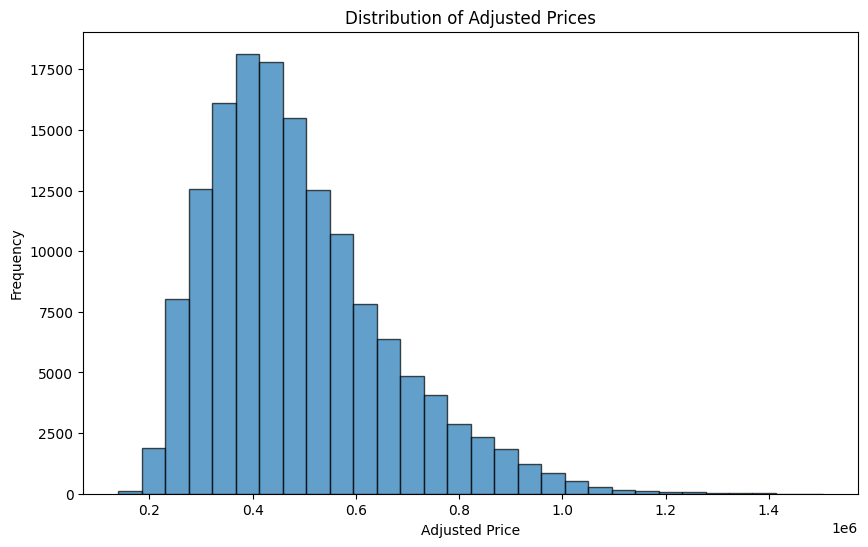

/var/folders/dh/rl06mgxn293dn9_qw9161yh00000gn/T/ipykernel_11450/3132215598.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)


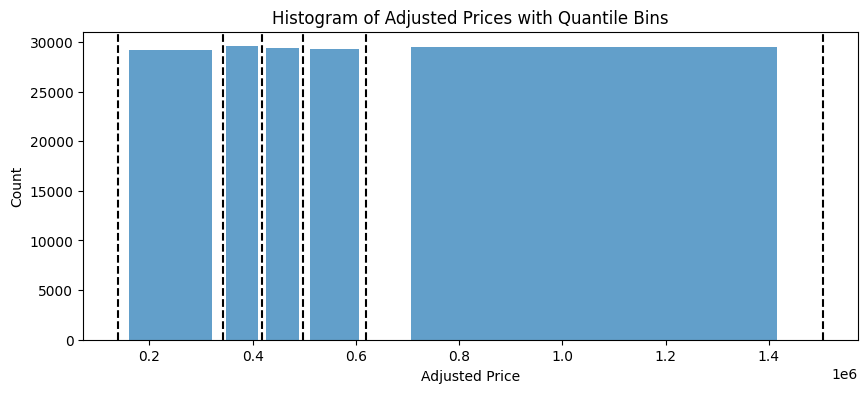

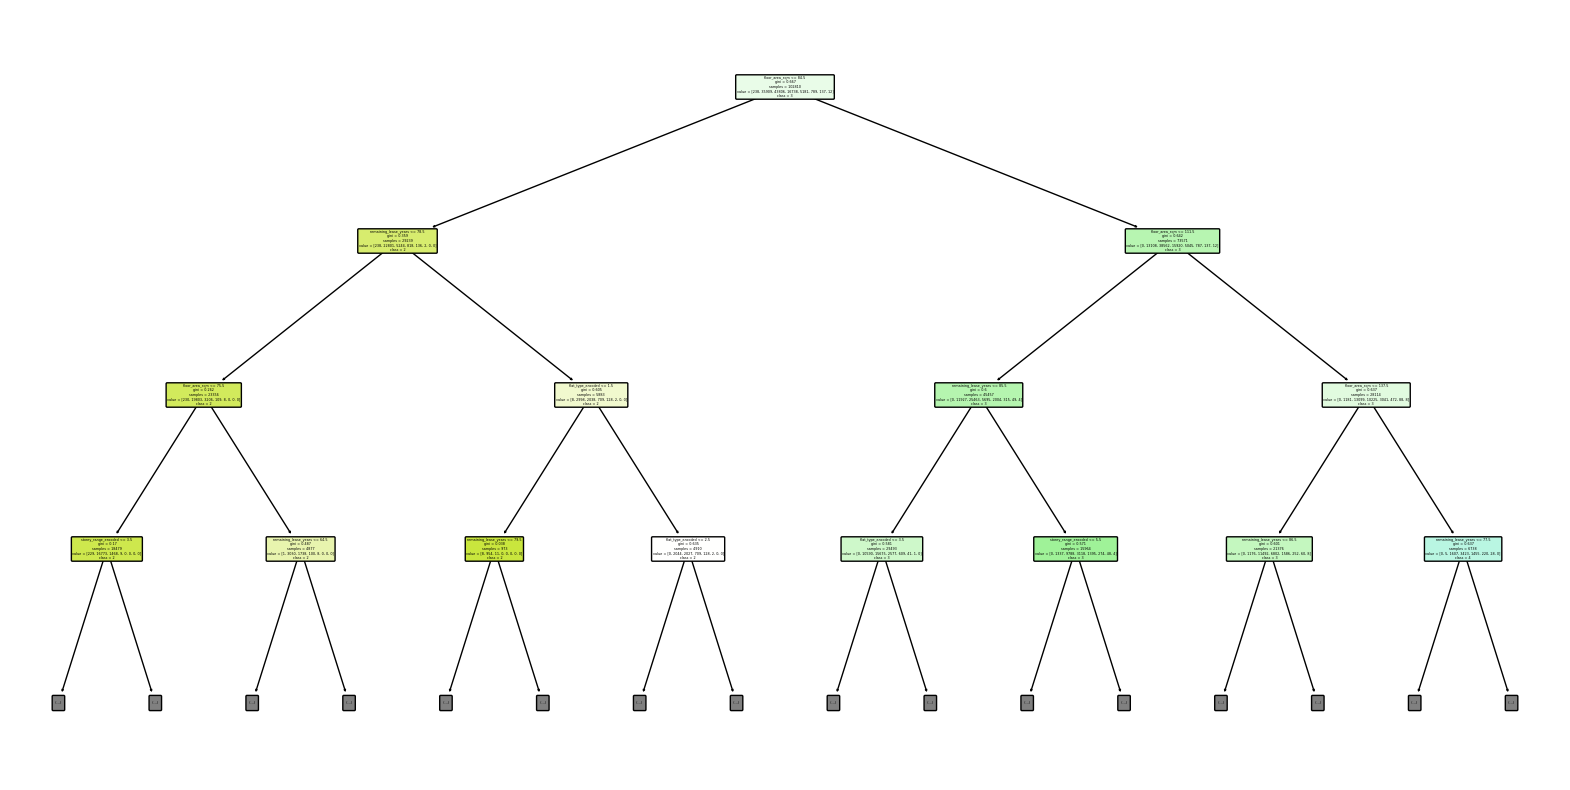

In [52]:
import numpy as np

# Visualize the distribution of adjusted_price
plt.figure(figsize=(10, 6))
plt.hist(df2['adjusted_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Adjusted Prices')
plt.xlabel('Adjusted Price')
plt.ylabel('Frequency')
plt.show()

# Determine appropriate bin edges based on the distribution
# For example, using quantiles
quantile_edges = df2['adjusted_price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = [1, 2, 3, 4, 5]
df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)

# Assuming you have already split your dataset into X and y, and trained the classifier 'clf'

# Plot the bins based on quantiles on the histogram
plt.figure(figsize=(10, 4))
for edge in quantile_edges:
    plt.axvline(x=edge, color='k', linestyle='--')
plt.hist(df2['adjusted_price'], bins=quantile_edges, rwidth=0.8, alpha=0.7)
plt.title('Histogram of Adjusted Prices with Quantile Bins')
plt.xlabel('Adjusted Price')
plt.ylabel('Count')
plt.show()

# Convert labels to string type to ensure compatibility with tree.plot_tree
labels_str = [str(label) for label in labels]

# Plot the decision tree with a limited depth for readability
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=labels_str, filled=True, rounded=True, max_depth=3)
plt.show()


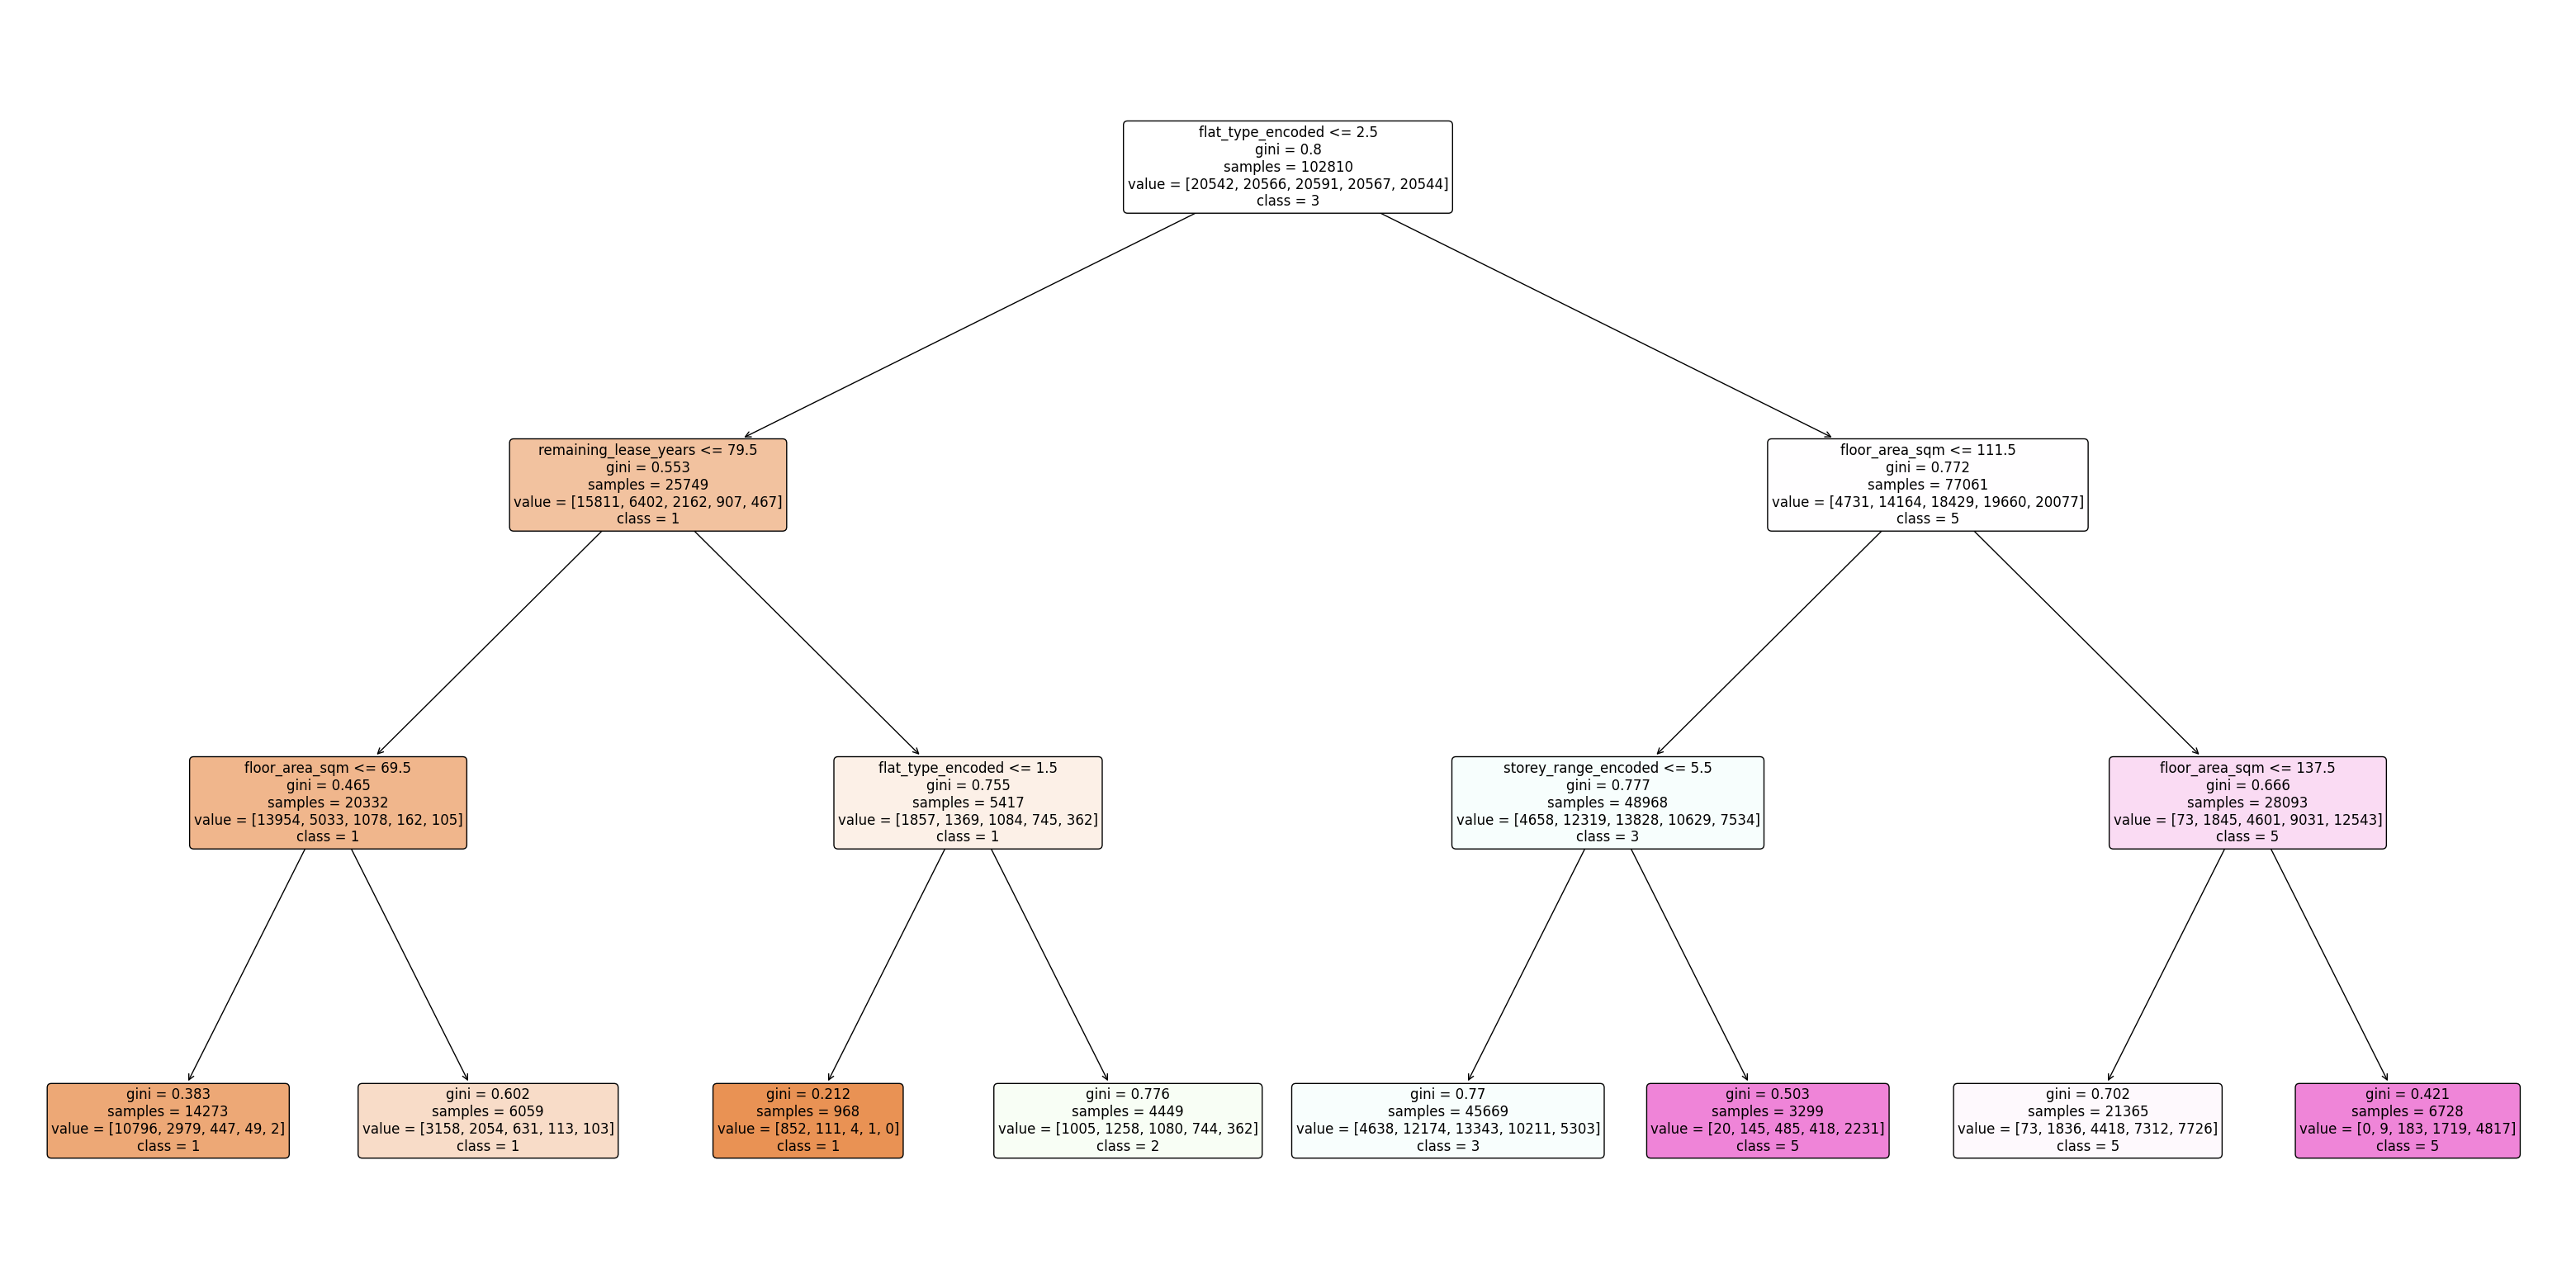

In [55]:
plt.figure(figsize=(40, 20))  # Set an even larger figure size if needed

# Plot the decision tree
decision_tree = tree.plot_tree(
    clf,
    feature_names=X.columns,
    class_names=labels_str,
    filled=True,
    rounded=True,
    fontsize=12  # Try increasing this value
)

# Increase the size of the leaf nodes
for o in decision_tree:
    if 'leaf' in o.get_text():
        o.set_size(20)

plt.show()


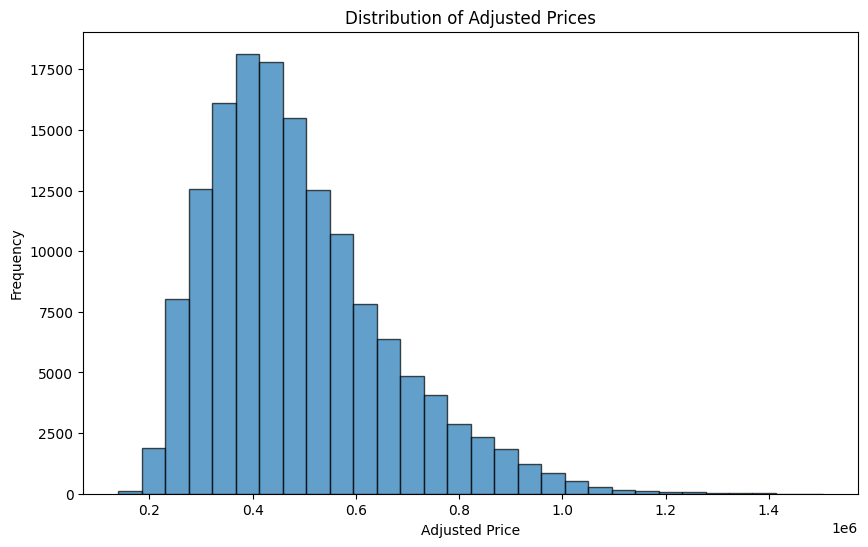

/var/folders/dh/rl06mgxn293dn9_qw9161yh00000gn/T/ipykernel_11450/3080901174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)


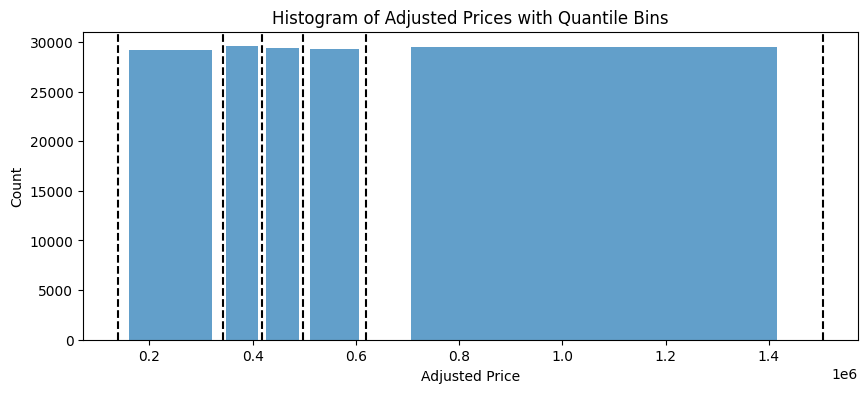

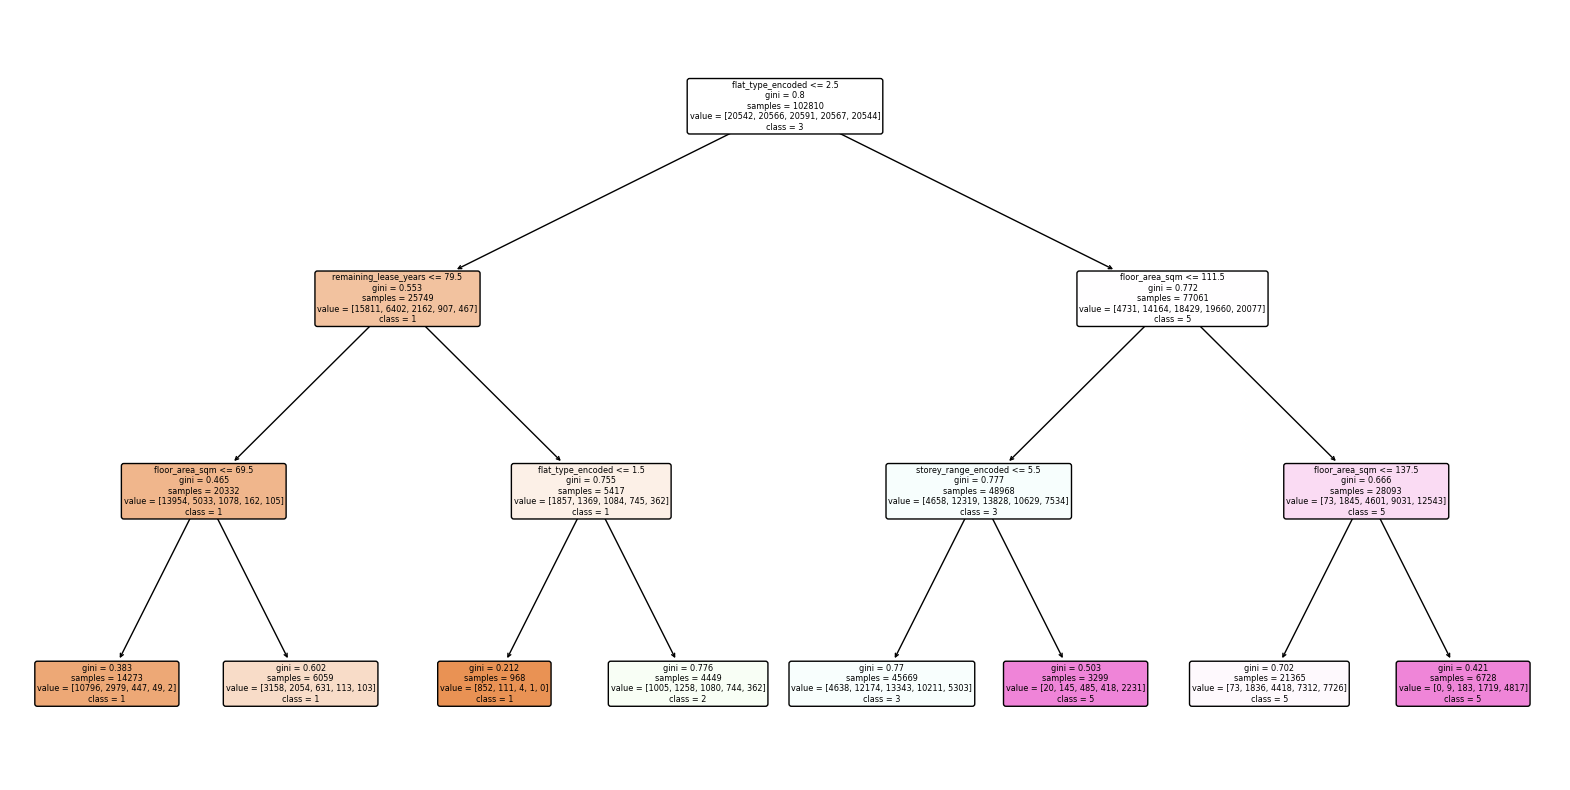

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming `df2` is already loaded in the environment with the appropriate structure.

# Visualize the distribution of adjusted_price
plt.figure(figsize=(10, 6))
plt.hist(df2['adjusted_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Adjusted Prices')
plt.xlabel('Adjusted Price')
plt.ylabel('Frequency')
plt.show()

# Determine appropriate bin edges based on the distribution
# For example, using quantiles
quantile_edges = df2['adjusted_price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = ['1', '2', '3', '4', '5']  # Convert labels to string type directly
df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)

# Split the dataset into features and target
X = df2[['flat_type_encoded', 'storey_range_encoded', 'floor_area_sqm', 'remaining_lease_years']]
y = df2['price_range']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)  # Limiting the depth of the tree
clf.fit(X_train, y_train)

# Plot the bins based on quantiles on the histogram
plt.figure(figsize=(10, 4))
for edge in quantile_edges:
    plt.axvline(x=edge, color='k', linestyle='--')
plt.hist(df2['adjusted_price'], bins=quantile_edges, rwidth=0.8, alpha=0.7)
plt.title('Histogram of Adjusted Prices with Quantile Bins')
plt.xlabel('Adjusted Price')
plt.ylabel('Count')
plt.show()

# Plot the decision tree with a limited depth for readability
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=labels, filled=True, rounded=True)
plt.show()
